# Building a supervised ML model to help my brother list his room on Airbnb NY

In my EDA I mentioned to you that my brother is pursuing his masters education from NYU. During the summer semester, he is planning to do an internship outside NY. I suggested to him that he should put up his room in NY on Airbnb to help himself out as he will stillbe paying rent to his landlord. He came back to me with the question - but how much do you think I should price it at? 

I decided to put my DS skills into use and build an ML model to predict how much he can expect his room to be priced at based on what we see about other listings.

![Photo by <a href="https://unsplash.com/@montanari?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Joe Montanari</a> on <a href="https://unsplash.com/s/photos/airbnb-house-new-york?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Unsplash</a>
  ](joe-montanari-Jwwnb6pQ-FU-unsplash.jpg "New York City")

My brother is not alone when it comes to not knowing what should be the optimal price for their listing. I am sure Airbnb have their own model on their platform to help out their hosts but as neither my brother or I have ever listed a place on Airbnb we don't know what it looks like.

But we do have some things to starte our research on. For instance, we did use Airbnb to rent places for travel so we know what the search process looks like for one side of the marketplace (i.e. renters). The photo below shows a screenshot from the Airbnb website when a potential renter is looking for a short-stay place to rent through Airbnb.

## Looking at the data we will be working with

We will be using the same dataset we used in the Airbnb EDA downloaded from Inside Airbnb.

We'll begin by importing some libraries:    

* `numpy` and `pandas` for data manipulation  
* `seaborn` and `matplotlib` for data visualization

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import warnings # to avoid warning messages
warnings.filterwarnings("ignore")

In [3]:
#Reading in the data
listings_data = pd.read_csv('listings.csv.gz', compression='gzip', error_bad_lines=False)

In [4]:
print(listings_data.shape)
print(listings_data.columns)

(39881, 75)
Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_a

Looking at the column names, there are 75 features for each listing. We are interested in features that are likely going to help us understand the price of the listing. To make the data set less cumbersome to work with, we’ll remove many of the columns in the original data set and assign it to a new variable.

Here are some of the more important columns (features) we’ll want to work with, because these are all characteristics that a renter might use to assess which listing they will choose:

`accommodates`: the number of guests the rental can accommodate  
`bedrooms`: number of bedrooms included in the rental  
`bathrooms_text`: number of bathrooms included in the rental  
`beds`: number of beds included in the rental   
`neighbourhood_group_cleansed`: neighbourhood group that the listing is located in  
`price`: nightly price for the rental  
`property_type`: type of property that the listing is
`number_of_reviews`: number of reviews that previous guests have left  
`host_identity_verified`:  whether the host identity is verified
`host_is_superhost`:  whether the host is a superhost

I have chosen the above based on the understanding of each feature from the data dictionary and the previous EDA exercise

In [5]:
listings_df = listings_data[
    ["accommodates","bedrooms","bathrooms_text","beds",
    "neighbourhood_group_cleansed","price", 
     "property_type","number_of_reviews",
    "host_identity_verified", "host_is_superhost"]
]

## Data cleaning

In [6]:
listings_df.head()

,accommodates,bedrooms,bathrooms_text,beds,neighbourhood_group_cleansed,price,property_type,number_of_reviews,host_identity_verified,host_is_superhost
0,2,1.0,1 shared bath,1.0,Brooklyn,$299.00,Private room in rental unit,9,t,f
1,1,NaN,1 bath,1.0,Manhattan,$175.00,Entire rental unit,49,t,f
2,2,1.0,NaN,1.0,Brooklyn,$60.00,Private room in rental unit,50,t,t
3,16,5.0,2.5 baths,10.0,Queens,$425.00,Entire townhouse,13,t,f
4,4,2.0,1.5 baths,2.0,Brooklyn,$275.00,Entire rental unit,3,t,f


In [7]:
listings_df.shape

(39881, 10)

In [8]:
 listings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39881 entries, 0 to 39880
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   accommodates                  39881 non-null  int64  
 1   bedrooms                      36098 non-null  float64
 2   bathrooms_text                39797 non-null  object 
 3   beds                          38997 non-null  float64
 4   neighbourhood_group_cleansed  39881 non-null  object 
 5   price                         39881 non-null  object 
 6   property_type                 39881 non-null  object 
 7   number_of_reviews             39881 non-null  int64  
 8   host_identity_verified        39831 non-null  object 
 9   host_is_superhost             39852 non-null  object 
dtypes: float64(2), int64(2), object(6)
memory usage: 3.0+ MB


The first step in the cleaning is where I would like to duplicates across all columns.

In [9]:
listings_df.drop_duplicates()
listings_df.shape

(39881, 10)

We didn't have any duplicates in the data. Our dataset at this point has 39,881 listings and 11 features.

### Exploring missing data

From the above, we see that there are some columns which have null values. We will investigate which null values we should be worried about and then decide what we want to do about it.

In [10]:
pd.options.display.max_rows = 400 #increases the viewing pane of my dataset

# Shows me the list of features  with proportion of  null values sorted in descending order.
(listings_df.isnull().sum()/listings_df.shape[0]*100).sort_values(ascending = False)

bedrooms                        9.485720
beds                            2.216594
bathrooms_text                  0.210627
host_identity_verified          0.125373
host_is_superhost               0.072716
accommodates                    0.000000
neighbourhood_group_cleansed    0.000000
price                           0.000000
property_type                   0.000000
number_of_reviews               0.000000
dtype: float64

*Observations:*

1. `bedrooms` have the most number of missing values i.e. around 10% of observations. I would not want to drop all these rows fromt the dataset. I will instead impute these values from another feature `accommodates` as I would expect these to be correlated. So we will take the average within each group of the accommodates coloumn.
2. The other columns which have missing values are `beds`, `bathrooms_text`, `host_identity_verified` and `host_is_superhost`. These collectively account for around 3% of the observations so I am comfortable dropping these.

I will start by looking at the accommodates feature deeper.

In [11]:
listings_df.accommodates.value_counts()

2     17735
4      6427
1      6128
3      3999
6      2080
5      1725
8       641
7       437
10      221
16      157
12      120
9        87
11       34
15       33
14       24
0        17
13       16
Name: accommodates, dtype: int64

It looks odd that there are 17 listings which a value of 0 in terms of number of people the listing can accommodate. I will see what the `bedrooms` column looks like for these rows.

In [12]:
listings_df[listings_df['accommodates'] == 0]

,accommodates,bedrooms,bathrooms_text,beds,neighbourhood_group_cleansed,price,property_type,number_of_reviews,host_identity_verified,host_is_superhost
22137,0,NaN,NaN,NaN,Manhattan,$0.00,Room in boutique hotel,0,t,NaN
22185,0,NaN,NaN,NaN,Manhattan,$0.00,Room in boutique hotel,0,t,NaN
22188,0,NaN,NaN,NaN,Manhattan,$0.00,Room in hotel,65,t,NaN
22196,0,NaN,NaN,NaN,Manhattan,$0.00,Room in boutique hotel,9,t,NaN
22271,0,NaN,NaN,NaN,Manhattan,$0.00,Room in hotel,19,t,NaN
22277,0,NaN,NaN,NaN,Manhattan,$0.00,Room in boutique hotel,42,t,NaN
22280,0,NaN,NaN,NaN,Manhattan,$0.00,Room in hotel,0,t,NaN
23080,0,NaN,NaN,NaN,Manhattan,$0.00,Room in boutique hotel,8,f,NaN
23802,0,NaN,NaN,NaN,Manhattan,$0.00,Room in hotel,0,t,NaN
23834,0,NaN,NaN,NaN,Manhattan,$0.00,Room in boutique hotel,161,t,NaN


These observations look a bit odd. The columns `bedrooms`, `bathrooms_text` and `beds` all have null values. The price also is 0 for each of these listings. Since these are only 17 observations, I wil drop them.

In [13]:
listings_df.drop(listings_df[listings_df.accommodates == 0].index, inplace=True)
listings_df.shape

(39864, 10)

Now we will impute the missing values in the `bedrooms` column with the average of each group in the `accommodates`column

In [14]:
listings_df["bedrooms"] = listings_df['bedrooms'].fillna(listings_df.groupby('accommodates')['bedrooms'].transform('mean'))


In [15]:
listings_df['bedrooms'] = round(listings_df['bedrooms'])

In [16]:
listings_df['bedrooms'].isna().sum()

0

In [17]:
#dropping all other null values and resetting index
listings_df = listings_df.dropna()
listings_df.reset_index(drop = True)

,accommodates,bedrooms,bathrooms_text,beds,neighbourhood_group_cleansed,price,property_type,number_of_reviews,host_identity_verified,host_is_superhost
0,2,1.0,1 shared bath,1.0,Brooklyn,$299.00,Private room in rental unit,9,t,f
1,1,1.0,1 bath,1.0,Manhattan,$175.00,Entire rental unit,49,t,f
2,16,5.0,2.5 baths,10.0,Queens,$425.00,Entire townhouse,13,t,f
3,4,2.0,1.5 baths,2.0,Brooklyn,$275.00,Entire rental unit,3,t,f
4,1,1.0,1 shared bath,1.0,Bronx,$60.00,Private room in rental unit,0,f,f
...,...,...,...,...,...,...,...,...,...,...
38902,1,1.0,1 shared bath,1.0,Manhattan,$62.00,Private room in rental unit,0,t,f
38903,2,1.0,1 bath,1.0,Queens,$157.00,Entire home,33,t,f
38904,4,1.0,1 bath,2.0,Manhattan,$108.00,Entire rental unit,52,t,t
38905,2,1.0,1 bath,2.0,Queens,$140.00,Entire rental unit,11,t,f


In [18]:
listings_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38907 entries, 0 to 39879
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   accommodates                  38907 non-null  int64  
 1   bedrooms                      38907 non-null  float64
 2   bathrooms_text                38907 non-null  object 
 3   beds                          38907 non-null  float64
 4   neighbourhood_group_cleansed  38907 non-null  object 
 5   price                         38907 non-null  object 
 6   property_type                 38907 non-null  object 
 7   number_of_reviews             38907 non-null  int64  
 8   host_identity_verified        38907 non-null  object 
 9   host_is_superhost             38907 non-null  object 
dtypes: float64(2), int64(2), object(6)
memory usage: 3.3+ MB


At this point, we have no null values. We have a total of 38,907 listings.

### Cleaning string values

The `bathrooms_text` column contains string values about the number of bathrooms in each listing. This is important information but string values won't let us work on them approporiately. So I will clean these values to extract the relevant information.

In [19]:
listings_df['bathrooms'] = listings_df["bathrooms_text"].str.extract('(\d*\.\d+|\d+)', expand=False).astype(float)

In [20]:
listings_df.head()

,accommodates,bedrooms,bathrooms_text,beds,neighbourhood_group_cleansed,price,property_type,number_of_reviews,host_identity_verified,host_is_superhost,bathrooms
0,2,1.0,1 shared bath,1.0,Brooklyn,$299.00,Private room in rental unit,9,t,f,1.0
1,1,1.0,1 bath,1.0,Manhattan,$175.00,Entire rental unit,49,t,f,1.0
3,16,5.0,2.5 baths,10.0,Queens,$425.00,Entire townhouse,13,t,f,2.5
4,4,2.0,1.5 baths,2.0,Brooklyn,$275.00,Entire rental unit,3,t,f,1.5
5,1,1.0,1 shared bath,1.0,Bronx,$60.00,Private room in rental unit,0,f,f,1.0


Next, we see that the `price` variable also is stored as string. We would expect this to be a numerical variable so we convert this into a float type

In [21]:
listings_df['price']= listings_df['price'].str.replace("$","")
listings_df['price']= listings_df['price'].str.replace(",","")
listings_df['price']= listings_df['price'].astype(float)

In [22]:
listings_df[["property_type"]].value_counts()

property_type                     
Entire rental unit                    16578
Private room in rental unit           10138
Private room in home                   2072
Entire condo                           1594
Entire home                            1457
Private room in townhouse              1043
Entire loft                             724
Entire townhouse                        652
Room in hotel                           635
Entire serviced apartment               597
Private room in condo                   581
Room in boutique hotel                  454
Shared room in rental unit              410
Entire guest suite                      386
Private room in serviced apartment      294
Private room in loft                    266
Private room in guest suite             127
Private room in casa particular          90
Entire place                             72
Entire guesthouse                        65
Room in aparthotel                       62
Private room in bed and breakfast        

Since there are quite a few ctaegories of property, we will simplify it by reducing the number of property types for our analysis. Looking at the Airbnb website, we see that one of the features that renters look is whether the listing offers the entire plaace, a private room or a shared room. So we will use these three categories.

In [23]:
listings_df["property_category"] = None
listings_df["property_category"][listings_df["property_type"].str.contains("Entire")] = "Entire place"
listings_df["property_category"][listings_df["property_type"].str.contains('Private|Room')] = "Private room"
listings_df["property_category"][listings_df["property_type"].str.contains("Shared")] = "Shared room"
listings_df["property_category"]=listings_df["property_category"].fillna("Others")

In [24]:
listings_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38907 entries, 0 to 39879
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   accommodates                  38907 non-null  int64  
 1   bedrooms                      38907 non-null  float64
 2   bathrooms_text                38907 non-null  object 
 3   beds                          38907 non-null  float64
 4   neighbourhood_group_cleansed  38907 non-null  object 
 5   price                         38907 non-null  float64
 6   property_type                 38907 non-null  object 
 7   number_of_reviews             38907 non-null  int64  
 8   host_identity_verified        38907 non-null  object 
 9   host_is_superhost             38907 non-null  object 
 10  bathrooms                     38837 non-null  float64
 11  property_category             38907 non-null  object 
dtypes: float64(4), int64(2), object(6)
memory usage: 3.9+ MB


In [25]:
listings_df["property_category"].value_counts()

Entire place    22237
Private room    16067
Shared room       527
Others             76
Name: property_category, dtype: int64

Finally, we see that the the columns `host_identity_verified` and `host_is_superhost` are also stored as string values. We expect them to be boolean values and will one hot encode them to make them more useful for further analysis. We will also one hot encode the `property category` and `neighourhood_group_cleansed` columns.

In [26]:
listings_df[['host_identity_verified', 'host_is_superhost']] = (listings_df[['host_identity_verified', 'host_is_superhost']] == 'TRUE').astype(int)

In [27]:
listings_df = pd.get_dummies(listings_df, columns = ['property_category','neighbourhood_group_cleansed'])

In [29]:
#dropping bathrooms_text  and property_type columns as we no longer need that
listings_clean_df = listings_df.drop(["bathrooms_text", "property_type"], axis =1)

listings_clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38907 entries, 0 to 39879
Data columns (total 17 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   accommodates                                38907 non-null  int64  
 1   bedrooms                                    38907 non-null  float64
 2   beds                                        38907 non-null  float64
 3   price                                       38907 non-null  float64
 4   number_of_reviews                           38907 non-null  int64  
 5   host_identity_verified                      38907 non-null  int32  
 6   host_is_superhost                           38907 non-null  int32  
 7   bathrooms                                   38837 non-null  float64
 8   property_category_Entire place              38907 non-null  uint8  
 9   property_category_Others                    38907 non-null  uint8  
 10  property_c

In [30]:
#Removing the rows with missing values of `bathrooms` column
listings_clean_df = listings_clean_df.dropna()
listings_clean_df.reset_index(drop = True)

,accommodates,bedrooms,beds,price,number_of_reviews,host_identity_verified,host_is_superhost,bathrooms,property_category_Entire place,property_category_Others,property_category_Private room,property_category_Shared room,neighbourhood_group_cleansed_Bronx,neighbourhood_group_cleansed_Brooklyn,neighbourhood_group_cleansed_Manhattan,neighbourhood_group_cleansed_Queens,neighbourhood_group_cleansed_Staten Island
0,2,1.0,1.0,299.0,9,0,0,1.0,0,0,1,0,0,1,0,0,0
1,1,1.0,1.0,175.0,49,0,0,1.0,1,0,0,0,0,0,1,0,0
2,16,5.0,10.0,425.0,13,0,0,2.5,1,0,0,0,0,0,0,1,0
3,4,2.0,2.0,275.0,3,0,0,1.5,1,0,0,0,0,1,0,0,0
4,1,1.0,1.0,60.0,0,0,0,1.0,0,0,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38832,1,1.0,1.0,62.0,0,0,0,1.0,0,0,1,0,0,0,1,0,0
38833,2,1.0,1.0,157.0,33,0,0,1.0,1,0,0,0,0,0,0,1,0
38834,4,1.0,2.0,108.0,52,0,0,1.0,1,0,0,0,0,0,1,0,0
38835,2,1.0,2.0,140.0,11,0,0,1.0,1,0,0,0,0,0,0,1,0


In [31]:
listings_clean_df.describe()

,accommodates,bedrooms,beds,price,number_of_reviews,host_identity_verified,host_is_superhost,bathrooms,property_category_Entire place,property_category_Others,property_category_Private room,property_category_Shared room,neighbourhood_group_cleansed_Bronx,neighbourhood_group_cleansed_Brooklyn,neighbourhood_group_cleansed_Manhattan,neighbourhood_group_cleansed_Queens,neighbourhood_group_cleansed_Staten Island
count,38837.000000,38837.000000,38837.000000,38837.000000,38837.000000,38837.0,38837.0,38837.000000,38837.000000,38837.000000,38837.000000,38837.000000,38837.000000,38837.000000,38837.000000,38837.000000,38837.000000
mean,2.946211,1.349821,1.642892,197.551183,27.013441,0.0,0.0,1.163671,0.571852,0.001931,0.412648,0.013570,0.038958,0.373021,0.421789,0.155007,0.011226
std,1.975625,0.715205,1.120027,354.482479,56.624887,0.0,0.0,0.445921,0.494817,0.043903,0.492317,0.115697,0.193497,0.483614,0.493851,0.361916,0.105360
min,1.000000,1.000000,1.000000,10.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,1.000000,1.000000,80.000000,1.000000,0.0,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,1.000000,1.000000,131.000000,5.000000,0.0,0.0,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.000000,1.000000,2.000000,220.000000,26.000000,0.0,0.0,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
max,16.000000,13.000000,24.000000,16500.000000,1480.000000,0.0,0.0,9.500000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


So at the end of our cleaning, we have 38,837 listings in our dataset.

## Visualising our data

We will first look at the price variable.

In [32]:
listings_clean_df.price.describe()

count    38837.000000
mean       197.551183
std        354.482479
min         10.000000
25%         80.000000
50%        131.000000
75%        220.000000
max      16500.000000
Name: price, dtype: float64

What immediately sticks out for me is the range of the price variable. I will visualise it in a boxplot to show this better.

A boxplot is a graphical and standardised way to display the distribution of data based on five key numbers- minimum, 1st Quartile (25th percentile),median (2nd Quartile/ 50th Percentile),3rd Quartile (75th percentile),maximum.
The minimum and maximum values are defined as Q1–1.5 * IQR and Q3 + 1.5 * IQR respectively(where IQR = Interquartire range). Any points that fall outside of these limits are referred to as outliers.

<AxesSubplot: xlabel='price'>

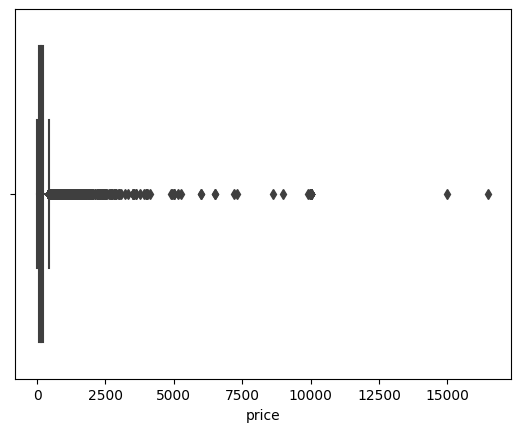

In [33]:
sns.boxplot(x=listings_clean_df['price'], width = 0.8)

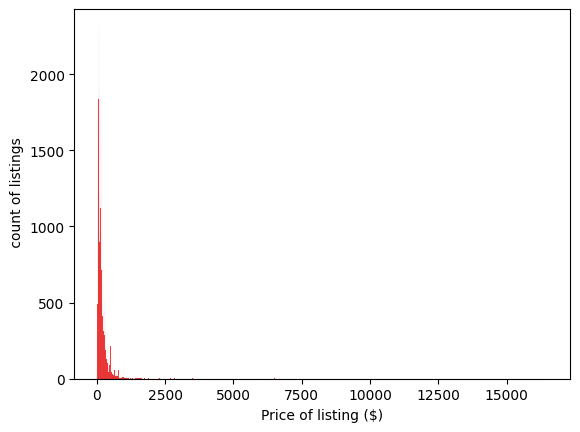

In [34]:
# Plotting the prices of listings on a histogram

p = sns.histplot( data = listings_clean_df, x = "price", color = "red")

p.set (xlabel = "Price of listing ($)", ylabel = " count of listings")

plt.show()

The charts don't look very pretty but it does show that we have a lot of outliers in our pricing data.So our pricing data is highly skewed on the right. Dealing with outliers needs some judgement. Outliers often are portrayed as inaccurate and inappropriate information that needs to be removed to obtain cleaned data. However, keeping these data points can have its merits.Outliers can be legitimate anomalies that are important for capturing information on the variable or topic of interest.

In this dataset, there is some possibility that the extremely high prices are a consequence of error on the part of the host while listing (such as adding an extra unintended 0) or it can be genuine reflecting the large avriability in prices in NY Airbnb listings. I will avoid directly dropping all outliers as it is not unrealistic to see such igh prices in some areas of NY such as Manhattan.

However, our price data is not normaly distributed. Since price is going to be our target (or outcome) varibale later on in our model, we would want it to be normally distributed for implementing models such as Linear regression. One way is to log transform the price variable. We do this below and replot the data.

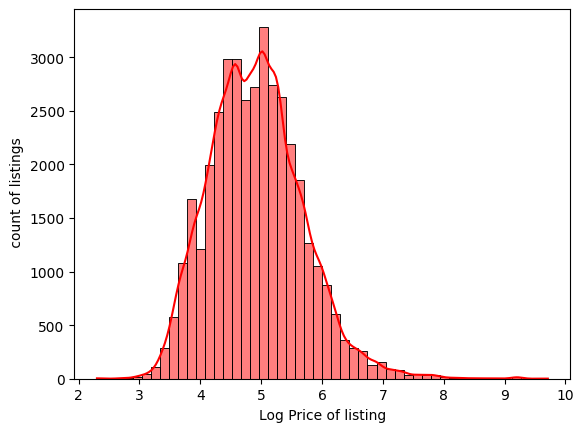

In [35]:
#Log transform our price column
listings_clean_df["log_price"] = np.log(listings_clean_df['price'])

#Plot a histogram of the price variable
p = sns.histplot( data = listings_clean_df, x = "log_price", color = "red", kde = True, bins = 50)

p.set (xlabel = "Log Price of listing", ylabel = " count of listings")

plt.show()

## ML model to predict house prices

Coming back to the goal of our analysis - we want to understand what would be the optimal price for my brother's place could be if he were to list it on Airbnb for the summer.I will be looking at two ML models in this analysis:

1. Linear regression model
2. KNN model

I start off by first looking at the correlations between different variables in our dataset

<AxesSubplot: >

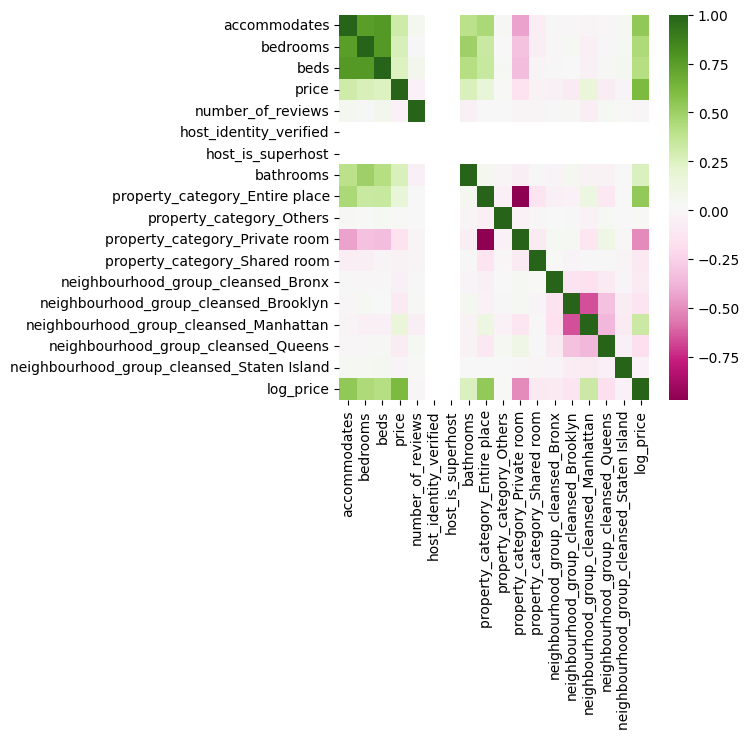

In [36]:
#Plotting a correlation matrix heatmap
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(listings_clean_df.corr(),cmap="PiYG",ax=ax)

*Observation:*

I am interested in looking at how the target variable is correlated with the other features. It looka like `log price` is positively somewhat correlated with `accommodates`, `bedrooms`, `beds`, `bathrooms` and to the categories of Entire place and Manhattan.

Now let's start building our model below

In [37]:
X = listings_clean_df.drop("log_price", axis =1)
y = listings_clean_df["log_price"]

In [38]:
#Splitting the data into a training and testing set

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state =42)

print(X_train.shape)
print(X_test.shape)

(31069, 17)
(7768, 17)


In [39]:
X.head()

,accommodates,bedrooms,beds,price,number_of_reviews,host_identity_verified,host_is_superhost,bathrooms,property_category_Entire place,property_category_Others,property_category_Private room,property_category_Shared room,neighbourhood_group_cleansed_Bronx,neighbourhood_group_cleansed_Brooklyn,neighbourhood_group_cleansed_Manhattan,neighbourhood_group_cleansed_Queens,neighbourhood_group_cleansed_Staten Island
0,2,1.0,1.0,299.0,9,0,0,1.0,0,0,1,0,0,1,0,0,0
1,1,1.0,1.0,175.0,49,0,0,1.0,1,0,0,0,0,0,1,0,0
3,16,5.0,10.0,425.0,13,0,0,2.5,1,0,0,0,0,0,0,1,0
4,4,2.0,2.0,275.0,3,0,0,1.5,1,0,0,0,0,1,0,0,0
5,1,1.0,1.0,60.0,0,0,0,1.0,0,0,1,0,1,0,0,0,0


### Linear Regression model

In [40]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

### K-Nearest Neighbours model

In [41]:
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor()#by default k=5
knn.fit(X_train, y_train)

KNeighborsRegressor()

## Evaluating the models

In [46]:
from sklearn.metrics import mean_squared_error
RMSE = {}
RMSE['Linear Regression'] = mean_squared_error(y_test, lr.predict(X_test)) ** 1/2 # to get the root of the mean squared error
RMSE['KNN'] = mean_squared_error(y_test, knn.predict(X_test)) ** 1/2


for key, value in RMSE.items():
    print(f'{key:20}{value}')

Linear Regression   0.0998637128142745
KNN                 0.0001469487259910069


Comparing both the models, we see that our KNN model has a lower Root Mean Squared Error (RMSE) comapred to our linear regression model. So we can use the KNN model to predict the optimal price of his listing based on the diffeent features we used in our model.

We can continue working on this. As next steps, here are a few things you can to do improve accuracy:

1. Try substituting in different values for k. We can try to understand what the optimal value of k should be through such an error plot or accuracy plot to find the most favorable k value.
2. Use cross-validation to imporve 
3. Go back to the original data set and convert some of the columns we removed to numeric (our Preparing and Cleaning Data for Machine Learning post will help you here) and experiment with adding different combinations of features.